In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt

from statistics import mean, mode, stdev

In [2]:
data = np.load('./training_data_with_labels.npz')

X = data['X']
y = data['y']

print(f'# of interactions: {X.shape[0]}')
print(f'# of anomalous users: {np.count_nonzero(y==1)}')
print(f'# of normal users: {np.count_nonzero(y==0)}')

XX = pd.DataFrame(X)
yy = pd.DataFrame(y)
XX.rename(columns={0:'user',1:'item',2:'rating'}, inplace=True)
yy.rename(columns={0:'user',1:'label'}, inplace=True)
yy = yy.sort_values(by=['user'])

print('# of items:', XX['item'].unique().shape[0])

# of interactions: 200381
# of anomalous users: 100
# of normal users: 1000
# of items: 1196


Get unique items and produce new attributes for sparse matrix

In [3]:
unique_items = XX['item'].unique()
unique_items.sort()

column_names = [f'item_{i}' for i in unique_items]

In [4]:
def get_user_rating(df):
    '''
        Get rating for any item that a user has interacted with
    '''
    user_rating_dict = {}

    for row in range(len(df)):
        current_user = df['user'][row]

        if current_user not in user_rating_dict:
            user_rating_dict[current_user] = {}

        item = df['item'][row]
        rating = df['rating'][row]

        user_rating_dict[current_user][f'item_{item}'] = rating

    return user_rating_dict

In [5]:
def create_sparse_matrix(user_rating_dict):
    '''
        Create a new sparse matrix whereby each row records a user's interactions with all items
        If there is an item that the user did not interact with, impute with value '0'
    '''
    new_data = []

    for user, movie_rating in user_rating_dict.items():
        new_record = {}
        new_record['user'] = user
        for item, rating in movie_rating.items():
            new_record[item] = rating

        new_data.append(new_record)

    new_df = pd.DataFrame(new_data)
    new_df = new_df.sort_values(by=['user'])
    new_df = new_df.reset_index(drop=True)
    new_df = new_df.fillna(new_df.median())

    return new_df

In [6]:
user_rating_dict = get_user_rating(XX)
user_rating_dict

{1572: {'item_0': 5,
  'item_13': 2,
  'item_30': 5,
  'item_32': 2,
  'item_51': 2,
  'item_67': 4,
  'item_91': 3,
  'item_97': 3,
  'item_98': 3,
  'item_110': 4,
  'item_111': 1,
  'item_116': 2,
  'item_129': 2,
  'item_132': 1,
  'item_139': 4,
  'item_144': 3,
  'item_146': 1,
  'item_155': 2,
  'item_164': 2,
  'item_194': 3,
  'item_209': 2,
  'item_212': 4,
  'item_223': 1,
  'item_224': 4,
  'item_228': 3,
  'item_235': 4,
  'item_242': 5,
  'item_245': 4,
  'item_246': 5,
  'item_247': 2,
  'item_253': 4,
  'item_257': 3,
  'item_265': 4,
  'item_271': 4,
  'item_280': 4,
  'item_296': 1,
  'item_299': 2,
  'item_301': 5,
  'item_316': 1,
  'item_320': 3,
  'item_321': 5,
  'item_324': 5,
  'item_331': 2,
  'item_336': 3,
  'item_343': 2,
  'item_346': 1,
  'item_354': 1,
  'item_362': 1,
  'item_371': 3,
  'item_372': 5,
  'item_375': 3,
  'item_379': 3,
  'item_380': 4,
  'item_381': 2,
  'item_399': 4,
  'item_402': 4,
  'item_419': 5,
  'item_424': 3,
  'item_455': 2,
 

In [7]:
X_sparse_df = create_sparse_matrix(user_rating_dict)
X_sparse_df

user  item_0  item_13  item_30  item_32  item_51  item_67  item_91  \
0     1000     1.0      3.0      4.0      3.0      2.0      4.0      4.0   
1     1001     4.0      5.0      4.0      3.0      2.0      5.0      5.0   
2     1002     4.0      5.0      4.0      3.0      3.0      4.0      4.0   
3     1003     3.0      5.0      2.0      4.0      2.0      2.0      3.0   
4     1004     5.0      3.0      5.0      3.0      2.0      5.0      3.0   
...    ...     ...      ...      ...      ...      ...      ...      ...   
1095  2095     4.0      4.0      4.0      3.0      2.0      4.0      4.0   
1096  2096     5.0      4.0      5.0      3.0      2.0      5.0      5.0   
1097  2097     4.0      4.0      4.0      3.0      2.0      4.0      4.0   
1098  2098     4.0      4.0      4.0      3.0      2.0      4.0      4.0   
1099  2099     2.0      4.0      3.0      3.0      2.0      4.0      4.0   

      item_97  item_98  ...  item_1043  item_1055  item_1110  item_1148  \
0         3.0      2.0  ...        3.0        3.0        2.0        3.0   
1         4.0      2.0  ...        3.0        3.0        2.0        3.0   
2         4.0      1.0  ...        3.0        3.0        2.0        3.0   
3         3.0      2.0  ...        3.0        3.0        2.0        3.0   
4         5.0      4.0  ...        3.0        3.0        2.0        3.0   
...       ...      ...  ...        ...        ...        ...        ...   
1095      3.0      3.0  ...        3.0        3.0        2.0        3.0   
1096      3.0      3.0  ...        3.0        3.0        2.0        3.0   
1097      3.0      3.0  ...        3.0        3.0        2.0        3.0   
1098      3.0      3.0  ...        3.0        3.0        2.0        3.0   
1099      0.0      1.0  ...        3.0        3.0        2.0        3.0   

      item_1149  item_1170  item_683  item_1167  item_985  item_1155  
0           2.0        3.0       3.0        1.0       3.0        5.0  
1           2.0        3.0       3.0        1.0       3.0        5.0  
2           2.0        3.0       3.0        1.0       3.0        5.0  
3           2.0        3.0       3.0        1.0       3.0        5.0  
4           2.0        3.0       3.0        1.0       3.0        5.0  
...         ...        ...       ...        ...       ...        ...  
1095        2.0        3.0       3.0        1.0       3.0        5.0  
1096        2.0        3.0       3.0        1.0       3.0        5.0  
1097        2.0        3.0       3.0        1.0       3.0        5.0  
1098        2.0        3.0       3.0        1.0       3.0        5.0  
1099        2.0        3.0       3.0        1.0       3.0        5.0  

[1100 rows x 1197 columns]

In [8]:
def get_item_rating_stats(df):
    '''
        Get the mean, median and standard deviation for each item
    '''
    item_mean = df.groupby('item')['rating'].mean()
    item_std = df.groupby('item')['rating'].std()
    item_median = df.groupby('item')['rating'].median()

    item_rating_dict = {}

    for item in list(item_mean.index):
        item_rating_dict[item] = {}
        item_rating_dict[item]['mean'] = item_mean[item]
        item_rating_dict[item]['median'] = item_median[item]
        item_rating_dict[item]['std'] = item_std[item]

    return item_rating_dict

In [9]:
def get_rating_diff_from_mean(user, user_rating_dict, item_rating_dict):
    '''
        Get an user's totalled rating difference from item's rating mean
    '''
    total_diff = 0
    for item in user_rating_dict[user].keys():
        item_id = item.split("_")[1]
        total_diff += (user_rating_dict[user][item] - item_rating_dict[int(item_id)]['mean']) ** 2

    return np.sqrt(total_diff / len(user_rating_dict[user].keys()))

In [10]:
def get_new_features(user_rating_dict, item_rating_dict):
    new_features = {}

    for user in user_rating_dict.keys():
        new_features[user] = {}
        new_features[user]['rating_mean']  = mean(user_rating_dict[user].values())
        new_features[user]['rating_mode']  = mode(user_rating_dict[user].values())
        new_features[user]['rating_std']   = stdev(user_rating_dict[user].values())
        new_features[user]['rating_count'] = len(user_rating_dict[user].values())
        new_features[user]['rating_diff']  = get_rating_diff_from_mean(user, user_rating_dict, item_rating_dict)

    return new_features

In [11]:
def create_feature_matrix(new_features):
    '''
        Create a matrix with newly created features
    '''

    feature_record = []

    for user in new_features.keys():
        new_record = {}
        new_record['user'] = user

        for attr in new_features[user]:
            new_record[attr] = new_features[user][attr]

        feature_record.append(new_record)

    new_features_df = pd.DataFrame(feature_record)
    new_features_df = new_features_df.sort_values(by=['user'])
    new_features_df = new_features_df.reset_index(drop=True)

    return new_features_df

In [12]:
item_rating_dict = get_item_rating_stats(XX)
new_features_dict = get_new_features(user_rating_dict, item_rating_dict)
X_new_features_df = create_feature_matrix(new_features_dict)
X_new_features_df

user  rating_mean  rating_mode  rating_std  rating_count  rating_diff
0     1000            3            4    0.000000            71     0.831479
1     1001            3            5    1.000000           151     1.200285
2     1002            3            4    0.000000           236     0.850227
3     1003            3            4    1.000000           551     1.020603
4     1004            3            3    1.000000           253     1.134604
...    ...          ...          ...         ...           ...          ...
1095  2095            3            5    1.414214            25     1.684854
1096  2096            4            4    0.000000            81     0.949666
1097  2097            3            4    0.000000            51     0.741501
1098  2098            4            4    0.000000           124     1.079143
1099  2099            3            4    1.414214           165     1.365534

[1100 rows x 6 columns]

Concatenating sparse matrix with new feature matrix

In [13]:
X_new_features_df = X_new_features_df.drop(labels='user', axis=1)
X_sparse_df = X_sparse_df.drop(labels='user', axis=1)

X_df = pd.concat([X_new_features_df, X_sparse_df], axis=1)
X_df

rating_mean  rating_mode  rating_std  rating_count  rating_diff  item_0  \
0               3            4    0.000000            71     0.831479     1.0   
1               3            5    1.000000           151     1.200285     4.0   
2               3            4    0.000000           236     0.850227     4.0   
3               3            4    1.000000           551     1.020603     3.0   
4               3            3    1.000000           253     1.134604     5.0   
...           ...          ...         ...           ...          ...     ...   
1095            3            5    1.414214            25     1.684854     4.0   
1096            4            4    0.000000            81     0.949666     5.0   
1097            3            4    0.000000            51     0.741501     4.0   
1098            4            4    0.000000           124     1.079143     4.0   
1099            3            4    1.414214           165     1.365534     2.0   

      item_13  item_30  item_32  item_51  ...  item_1043  item_1055  \
0         3.0      4.0      3.0      2.0  ...        3.0        3.0   
1         5.0      4.0      3.0      2.0  ...        3.0        3.0   
2         5.0      4.0      3.0      3.0  ...        3.0        3.0   
3         5.0      2.0      4.0      2.0  ...        3.0        3.0   
4         3.0      5.0      3.0      2.0  ...        3.0        3.0   
...       ...      ...      ...      ...  ...        ...        ...   
1095      4.0      4.0      3.0      2.0  ...        3.0        3.0   
1096      4.0      5.0      3.0      2.0  ...        3.0        3.0   
1097      4.0      4.0      3.0      2.0  ...        3.0        3.0   
1098      4.0      4.0      3.0      2.0  ...        3.0        3.0   
1099      4.0      3.0      3.0      2.0  ...        3.0        3.0   

      item_1110  item_1148  item_1149  item_1170  item_683  item_1167  \
0           2.0        3.0        2.0        3.0       3.0        1.0   
1           2.0        3.0        2.0        3.0       3.0        1.0   
2           2.0        3.0        2.0        3.0       3.0        1.0   
3           2.0        3.0        2.0        3.0       3.0        1.0   
4           2.0        3.0        2.0        3.0       3.0        1.0   
...         ...        ...        ...        ...       ...        ...   
1095        2.0        3.0        2.0        3.0       3.0        1.0   
1096        2.0        3.0        2.0        3.0       3.0        1.0   
1097        2.0        3.0        2.0        3.0       3.0        1.0   
1098        2.0        3.0        2.0        3.0       3.0        1.0   
1099        2.0        3.0        2.0        3.0       3.0        1.0   

      item_985  item_1155  
0          3.0        5.0  
1          3.0        5.0  
2          3.0        5.0  
3          3.0        5.0  
4          3.0        5.0  
...        ...        ...  
1095       3.0        5.0  
1096       3.0        5.0  
1097       3.0        5.0  
1098       3.0        5.0  
1099       3.0        5.0  

[1100 rows x 1201 columns]

In [14]:
y_df = yy.drop(yy.columns[0], axis=1)
y_df

label
0         0
1         0
2         0
3         0
4         0
...     ...
1095      0
1096      0
1097      0
1098      0
1099      0

[1100 rows x 1 columns]

## Training autoencoder

Create training, validation and test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train data size:\n", X_train.shape)
print("Test data size:\n", X_test.shape)
print("Validation data size:\n", X_val.shape)

Train data size:
 (660, 1201)
Test data size:
 (220, 1201)
Validation data size:
 (220, 1201)


Normalise data

In [16]:
sc = MinMaxScaler()
sc.fit(X_train)

X_train_norm = sc.transform(X_train)
X_val_norm = sc.transform(X_val)
X_test_norm = sc.transform(X_test)

Divide the dataset into normal user and anomolous user

In [17]:
y_train = y_train.astype(bool)
y_val = y_val.astype(bool)
y_test = y_test.astype(bool)

def filter_arr(x, y, boolean_val):
  result = []
  for row in range(len(x)):
    if y.iloc[row, 0] == boolean_val:
      result.append(x[row])

  return np.array(result)

normal_train_data = filter_arr(X_train_norm, y_train, 0)
normal_val_data = filter_arr(X_val_norm, y_val, 0)
normal_train_data = filter_arr(X_test_norm, y_test, 0)

anomalous_train_data = filter_arr(X_train_norm, y_train, 1)
anomalous_val_data = filter_arr(X_val_norm, y_val, 1)
anomalous_test_data = filter_arr(X_test_norm, y_test, 1)

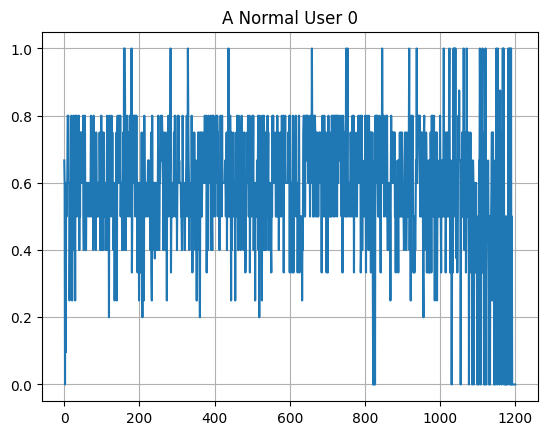

In [18]:
plt.grid()
plt.plot(np.arange(X_train_norm.shape[1]), normal_train_data[0])
plt.title("A Normal User 0")
plt.show()

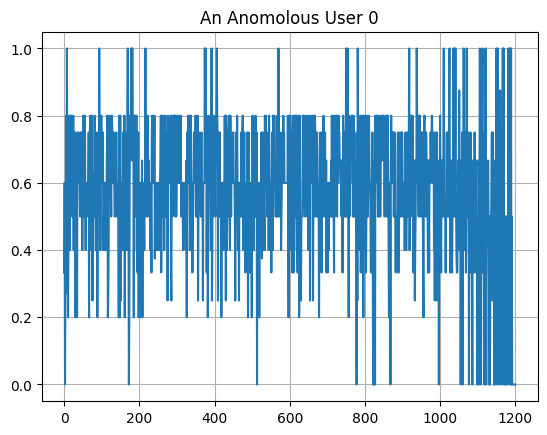

In [19]:
plt.grid()
plt.plot(np.arange(X_train_norm.shape[1]), anomalous_train_data[0])
plt.title("An Anomolous User 0")
plt.show()

Creating an autoencoder

In [20]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = Sequential([
      Dense(1024, input_dim=X_train_norm.shape[1], activation="relu"),
      Dense(512, activation="relu"),
      Dense(256, activation="relu"),
      Dense(128, activation="relu"),
      Dense(64, activation="relu"),
      Dense(32, activation="relu"),
      Dense(16, activation="relu"),
      Dense(8, activation="relu", activity_regularizer=tf.keras.regularizers.L1(0.0001)),
    ])

    self.decoder = Sequential([
      Dense(8, activation="relu"),
      Dense(16, activation="relu"),
      Dense(32, activation="relu"),
      Dense(64, activation="relu"),
      Dense(128, activation="relu"),
      Dense(256, activation="relu"),
      Dense(512, activation="relu"),
      Dense(1024, activation="relu"),
      Dense(X_train_norm.shape[1], activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-04 13:37:22.876089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-04 13:37:22.876189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
autoencoder.compile(optimizer=Adam(), loss='mae')

In [22]:
early_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

Training phase

In [23]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                            epochs=50,
                            batch_size=32,
                            verbose=1,
                            validation_data=(normal_val_data, normal_val_data),
                            callbacks=[early_cb],
                            shuffle=True)

Epoch 1/50


2023-03-04 13:37:23.144659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-04 13:37:23.739848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.1702

2023-03-04 13:37:24.881936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 118ms/step - loss: 0.1702 - val_loss: 0.1318
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0978 - val_loss: 0.0649
Epoch 3/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0570 - val_loss: 0.0481
Epoch 4/50
7/7 [==============================] - 0s 37ms/step - loss: 0.0443 - val_loss: 0.0428
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0395 - val_loss: 0.0375
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 0.0366 - val_loss: 0.0367
Epoch 7/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0346 - val_loss: 0.0374
Epoch 8/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0343 - val_loss: 0.0332
Epoch 9/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0338 - val_loss: 0.0344
Epoch 10/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0329 - val_loss: 0.0347
Epoch 11/50
7/7 [======================

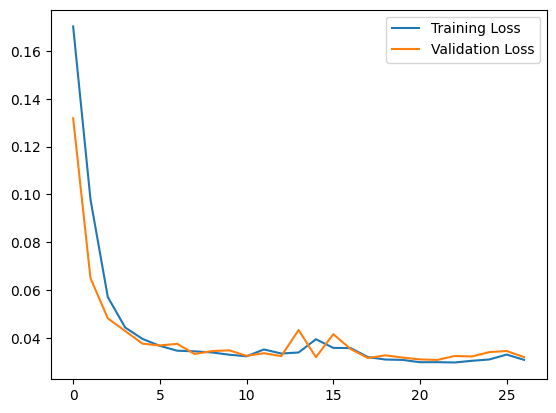

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

7/7 [==============================] - 0s 14ms/step


2023-03-04 13:37:29.750628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


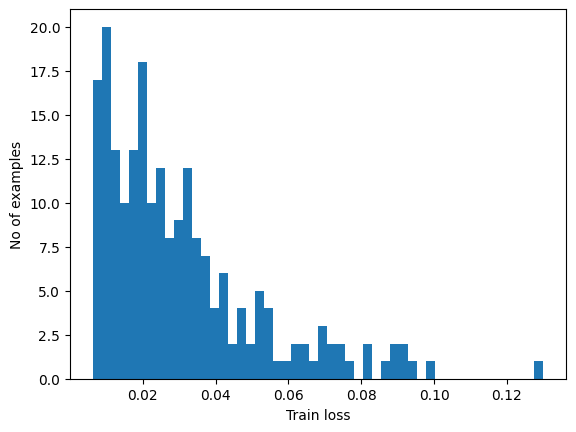

In [25]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
anomalous_data = np.concatenate((anomalous_train_data, anomalous_val_data, anomalous_test_data))
anomalous_data.shape

(100, 1201)

1/1 [==============================] - 0s 100ms/step


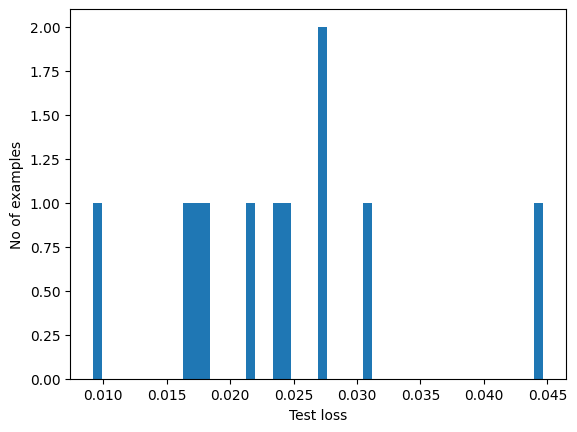

In [27]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [28]:
np.mean(test_loss)

0.02370575901572924

Prediction

In [31]:
def predict(model, data, low_threshold, high_threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    # low_bound_anomaly = tf.math.less(loss, low_threshold)
    # high_bound_anomaly = tf.math.greater(loss, high_threshold)
    # return tf.math.logical_or(low_bound_anomaly, high_bound_anomaly)

    return tf.math.less(loss, low_threshold)

def print_stats(predictions, labels):
    print(predictions)
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("ROC = {}".format(roc_auc_score(labels, predictions)))

In [33]:
np.mean(train_loss)

0.030412060087392317

In [34]:
preds = predict(autoencoder, X_test_norm, np.mean(train_loss), np.mean(train_loss) + np.std(train_loss))
print_stats(preds, y_test)

tf.Tensor(
[False  True  True  True  True  True  True False  True  True False False
  True  True  True  True False  True  True  True False  True False  True
 False False  True  True False  True False  True  True  True  True  True
 False False  True  True False False  True False False  True  True False
  True  True False False  True  True False False  True  True  True False
  True False  True False False  True  True  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False  True  True
 False False False  True  True  True  True  True False  True  True False
 False False  True False  True False  True False False  True  True False
  True  True  True  True  True  True  True  True  True  True  True False
  True False False  True False  True False  True False  True False  True
  True  True False  True  True False  True  True  True  True False  True
 False  True False  True False False Fal